In [1]:
import numpy as np
# np.seterr(divide='raise')
from numpy import exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.integrate import fixed_quad, quadrature, quad, nquad

import sys

sys.path.append("../Codes/")
from Hall1997 import *
from quad_utils import *
from angle_Hall1997 import *

In [2]:
mu = 1
sigma = 1
a = 1
theta = 0.3

upper_bdy = lambda t: a - theta * t
lower_bdy = lambda t: -a + theta * t

$X_t$ is an 1D stochastic process, let $\mathcal{T}=\inf\{t\ge0: X_t\ge l(t)\text{ or }X_t\ge u(t)\}$. We want to study the stopped process $X_{t\wedge\mathcal{T}}$. Let $p(x,t|y,s)$ be the transition probability density of $X_{t\wedge\mathcal{T}}$, defined as $p(x,t|y,s)\mathrm{d}x=\mathbb{P}(X_{t\wedge \mathcal{T}}\in\mathrm{d}x|X_{s\wedge \mathcal{T}}=y)$.



The Chapman-Kolmogorov equation writes
$$
p(x,t|y,s)=\int p(z,r|y,s)p(x, t|z,r)\mathrm{d}z
$$
for $s\le r\le t$. We want to numerically verify this.


In [3]:
# p = lambda T, x0, x, a: density_vertical(x, mu=mu, a=a, b=theta, x0=x0, T=T, trunc_num=100, if_logsumexp=False)
p = lambda x, t, y, s: density_vertical(x, mu=mu, a=a - theta * s, b=theta, x0=y, T=t - s, trunc_num=100)

For our case, let $l(0)\le x^{(0)}\le u(0)$ be fixed, C-K equation becomes
$$
\begin{aligned}
p(x^{(2)},t^{(2)}|x^{(0)},0)&=\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)}) \mathrm{d}x^{(1)}\\
& \text{for  }l(t^{(2)})\le x^{(2)}\le u(t^{(2)})\\
p(x^{(3)},t^{(3)}|x^{(0)},0)&=\int_{l(t^{(2)})}^{u(t^{(2)})}\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)})p(x^{(3)},t^{(3)}|x^{(2)},t^{(2)})\mathrm{d}x^{(1)}\mathrm{d}x^{(2)}\\
&\text{for  }l(t^{(3)})\le x^{(3)}\le u(t^{(3)})\\
p(x^{(4)},t^{(4)}|x^{(0)},0)&=\int_{l(t^{(3)})}^{u(t^{(3)})}\int_{l(t^{(2)})}^{u(t^{(2)})}\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)})p(x^{(3)},t^{(3)}|x^{(2)},t^{(2)})p(x^{(4)},t^{(4)}|x^{(3)},t^{(3)}) \mathrm{d}x^{(1)}\mathrm{d}x^{(2)}\mathrm{d}x^{(3)}\\
&\text{for }l(t^{(4)})\le x^{(4)}\le u(t^{(4)})\\
&\cdots
\end{aligned}
$$
We can calculate the integral via multi-dimensional Gauss-Legendre quadrature. Note that the above can be easily integrated to get the formula for the case where the density of $X_0$ is $f(x)$ instead of $\delta(x-x_0)$.

In [4]:
# collapse at a / theta
T1, T2, T3, T4 = 0.5, 0.3, 1, 0.5 
t1, t2, t3, t4 = np.cumsum([T1, T2, T3, T4])
x0 = -0.5

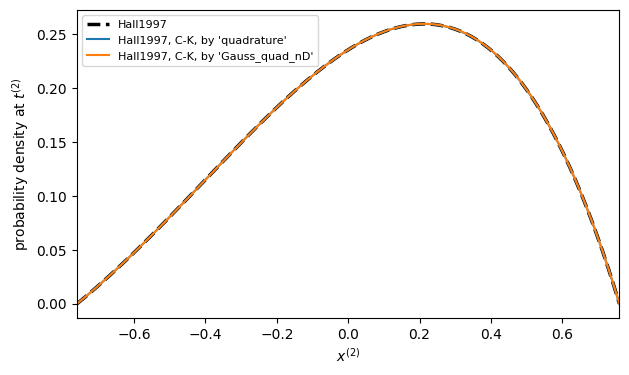

In [5]:
# Gaussian Quadrature, two stage time marching

x2s = np.linspace(lower_bdy(t2), upper_bdy(t2), num=100)
p2s = []
p2s_quad = []
p2s_gquad_nD = []
for x2 in x2s:
    p2s.append(p(x2, t2, x0, 0))
    integrand = lambda x1: p(x1, t1, x0, 0) * p(x2, t2, x1, t1)
    p2s_quad.append(quadrature(integrand, lower_bdy(t1), upper_bdy(t1))[0])
    p2s_gquad_nD.append(Gauss_quad_nD(integrand, [[lower_bdy(t1), upper_bdy(t1)]]))

fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
ax.plot(x2s, p2s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax.plot(x2s, p2s_quad, label="Hall1997, C-K, by 'quadrature'")
ax.plot(x2s, p2s_gquad_nD, label="Hall1997, C-K, by 'Gauss_quad_nD'")
ax.legend(fontsize=8)
ax.set_xlabel("$x^{(2)}$")
ax.set_ylabel("probability density at $t^{(2)}$")
ax.autoscale(tight=True, axis="x")
plt.show()

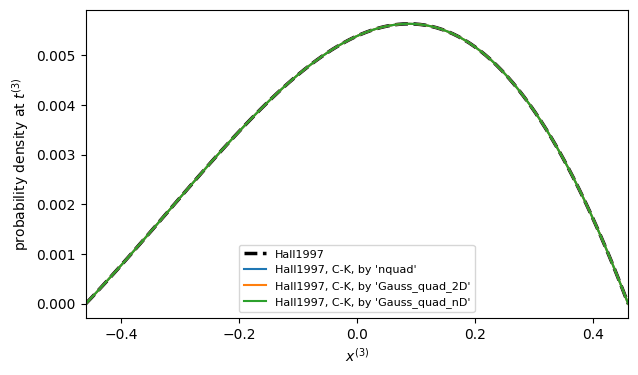

In [6]:
# Gaussian Quadrature, three stage time marching

x3s = np.linspace(lower_bdy(t3), upper_bdy(t3), num=100)
p3s = []
p3s_nquad = []
p3s_gquad_2D = []
p3s_gquad_nD = []
for x3 in x3s:
    p3s.append(p(x3, t3, x0, 0))
    integrand = lambda x1, x2: p(x1, t1, x0, 0) * p(x2, t2, x1, t1) * p(x3, t3, x2, t2)
    p3s_nquad.append(nquad(integrand, [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]])[0])
    p3s_gquad_2D.append(Gauss_quad_2D(integrand, [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]]))
    p3s_gquad_nD.append(Gauss_quad_nD(integrand, [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]]))

fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
ax.plot(x3s, p3s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax.plot(x3s, p3s_nquad, label="Hall1997, C-K, by 'nquad'")
ax.plot(x3s, p3s_gquad_2D, label="Hall1997, C-K, by 'Gauss_quad_2D'")
ax.plot(x3s, p3s_gquad_nD, label="Hall1997, C-K, by 'Gauss_quad_nD'")
ax.legend(fontsize=8)
ax.set_xlabel("$x^{(3)}$")
ax.set_ylabel("probability density at $t^{(3)}$")
ax.autoscale(tight=True, axis="x")
plt.show()

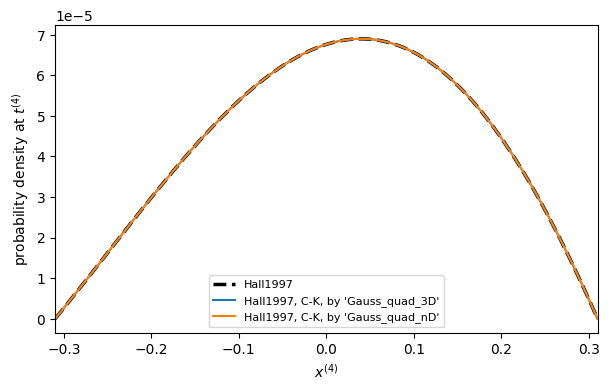

In [7]:
# Gaussian Quadrature, four stage time marching

x4s = np.linspace(lower_bdy(t4), upper_bdy(t4), num=100)
p4s = []
p4s_nquad = []  # takes 4 minutes
p4s_gquad_3D = []  # takes fraction of a second
p4s_gquad_nD = []
for x4 in x4s:
    p4s.append(p(x4, t4, x0, 0))
    integrand = lambda x1, x2, x3: p(x1, t1, x0, 0) * p(x2, t2, x1, t1) * p(x3, t3, x2, t2) * p(x4, t4, x3, t3)
    # # commented, this computation takes too much time
    # p4s_nquad.append(nquad(integrand, [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)], [lower_bdy(t3), upper_bdy(t3)]])[0])
    p4s_gquad_3D.append(Gauss_quad_3D(integrand, [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)], [lower_bdy(t3), upper_bdy(t3)]]))
    p4s_gquad_nD.append(Gauss_quad_nD(integrand, [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)], [lower_bdy(t3), upper_bdy(t3)]]))

fig, ax = plt.subplots(figsize=(7, 4), dpi=100)
ax.plot(x4s, p4s, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
# ax.plot(x4s, p4s_nquad, label="Hall1997, C-K, by 'nquad'")
ax.plot(x4s, p4s_gquad_3D, label="Hall1997, C-K, by 'Gauss_quad_3D'")
ax.plot(x4s, p4s_gquad_nD, label="Hall1997, C-K, by 'Gauss_quad_nD'")
ax.legend(fontsize=8)
ax.set_xlabel("$x^{(4)}$")
ax.set_ylabel("probability density at $t^{(4)}$")
ax.autoscale(tight=True, axis="x")
plt.show()

In [8]:
# time comparison
x4_test = 0.2
integrand = lambda x1, x2, x3: p(x1, t1, x0, 0) * p(x2, t2, x1, t1) * p(x3, t3, x2, t2) * p(x4_test, t4, x3, t3)
%timeit -r 5 -n 1 nquad(integrand,[[lower_bdy(t1), upper_bdy(t1)],[lower_bdy(t2), upper_bdy(t2)],[lower_bdy(t3), upper_bdy(t3)]])
%timeit -r 5 -n 100 Gauss_quad_3D(integrand,[[lower_bdy(t1), upper_bdy(t1)],[lower_bdy(t2), upper_bdy(t2)],[lower_bdy(t3), upper_bdy(t3)]], order=20)
%timeit -r 5 -n 100 Gauss_quad_nD(integrand,[[lower_bdy(t1), upper_bdy(t1)],[lower_bdy(t2), upper_bdy(t2)],[lower_bdy(t3), upper_bdy(t3)]], orders=20)

2.85 s ± 57.4 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)
1.93 ms ± 99.8 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)
2.93 ms ± 105 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)


we also have the first passage time densities at the upper boundary and lower boundary, $f_u(t|y, s)$ and $f_l(t|y, s)$ respectively

By a similar manner, we have
$$
\begin{aligned}
f_u(t|x^{(0)},0)&=\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)f_u(t|x^{(1)}, t^{(1)}) \mathrm{d}x^{(1)}, \text{ for } t^{(1)}\le t\le t^{(2)}\\
f_u(t|x^{(0)},0)&=\int_{l(t^{(2)})}^{u(t^{(2)})} p(x^{(2)},t^{(2)}|x^{(0)}, 0)f_u(t|x^{(2)}, t^{(2)}) \mathrm{d}x^{(2)}\\
&=\int_{l(t^{(2)})}^{u(t^{(2)})} \int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)}) f_u(t|x^{(2)}, t^{(2)}) \mathrm{d}x^{(1)}\mathrm{d}x^{(2)}, \text{ for } t^{(2)}\le t\le t^{(3)}\\
f_u(t|x^{(0)},0)&=\int_{l(t^{(3)})}^{u(t^{(3)})} p(x^{(3)},t^{(3)}|x^{(0)}, 0)f_u(t|x^{(3)}, t^{(3)}) \mathrm{d}x^{(3)}\\
&=\int_{l(t^{(3)})}^{u(t^{(3)})} \int_{l(t^{(2)})}^{u(t^{(2)})}\int_{l(t^{(1)})}^{u(t^{(1)})} p(x^{(1)},t^{(1)}|x^{(0)}, 0)p(x^{(2)},t^{(2)}|x^{(1)},t^{(1)})p(x^{(3)},t^{(3)}|x^{(2)},t^{(2)})f_u(t|x^{(3)}, t^{(3)}) \mathrm{d}x^{(1)}\mathrm{d}x^{(2)}\mathrm{d}x^{(3)}, \text{ for } t^{(3)}\le t\le t^{(4)}\\
\end{aligned}
$$
the formula is similar for $f_l(t|x_0,0)$.

In [9]:
fu = lambda t, y, s: density_upper(t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100)
fl = lambda t, y, s: density_lower(t-s, mu=mu, a=a - theta * s, b=theta, x0=y, trunc_num=100)

In [10]:
# reference
eps = 1e-2
ts = np.linspace(eps, t4 - eps, 100)

probu_list = []
for t in ts:
    probu_list.append(fu(t, x0, 0))

probl_list = []
for t in ts:
    probl_list.append(fl(t, x0, 0))

In [11]:
# first stage, analytical
t1s = np.linspace(eps, t1 - eps, 100)
p1u_list = []
p1u_fun_list = []
for t in t1s:
    p1u_list.append(fu(t, x0, 0))
    p1u_fun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu], t_list=[], a=a, theta=theta, x0=x0, bdy=1))
p1l_list = []
p1l_fun_list = []
for t in t1s:
    p1l_list.append(fl(t, x0, 0))
    p1l_fun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu], t_list=[], a=a, theta=theta, x0=x0, bdy=-1))

# second stage, 1D integral
t2s = np.linspace(t1 + eps, t2 - eps, 100)
int_range = [[lower_bdy(t1), upper_bdy(t1)]]
int_orders = [20]
p2u_list = []
p2u_fun_list = []
for t in t2s:
    integrand = lambda x1: p(x1, t1, x0, 0) * fu(t, x1, t1)
    p2u_list.append(Gauss_quad_nD(integrand, int_range, int_orders))
    p2u_fun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu, mu], t_list=[t1], a=a, theta=theta, x0=x0, bdy=1))
p2l_list = []
p2l_fun_list = []
for t in t2s:
    integrand = lambda x1: p(x1, t1, x0, 0) * fl(t, x1, t1)
    p2l_list.append(Gauss_quad_nD(integrand, int_range, int_orders))
    p2l_fun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu, mu], t_list=[t1], a=a, theta=theta, x0=x0, bdy=-1))
    
# third stage, 2D integral
t3s = np.linspace(t2 + eps, t3 - eps, 100)
int_range = [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)]]
int_orders = [5, 20]
p3u_list = []
p3u_fun_list = []
for t in t3s:
    integrand = lambda x1, x2: p(x2, t2, x1, t1) * p(x1, t1, x0, 0) * fu(t, x2, t2)
    p3u_list.append(Gauss_quad_nD(integrand, int_range, int_orders))
    p3u_fun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu, mu, mu], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=1))
p3l_list = []
p3l_fun_list = []
for t in t3s:
    integrand = lambda x1, x2: p(x2, t2, x1, t1) * p(x1, t1, x0, 0) * fl(t, x2, t2)
    p3l_list.append(Gauss_quad_nD(integrand, int_range, int_orders))
    p3l_fun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu, mu, mu], t_list=[t1, t2], a=a, theta=theta, x0=x0, bdy=-1))

# fourth stage, 3D integral
t4s = np.linspace(t3 + eps, t4 - eps, 100)
int_range = [[lower_bdy(t1), upper_bdy(t1)], [lower_bdy(t2), upper_bdy(t2)], [lower_bdy(t3), upper_bdy(t3)]]
int_orders = [5, 5, 20]
p4u_list = []
p4u_fun_list = []
for t in t4s:
    integrand = lambda x1, x2, x3: p(x3, t3, x2, t2) * p(x2, t2, x1, t1) * p(x1, t1, x0, 0) * fu(t, x3, t3)
    p4u_list.append(Gauss_quad_nD(integrand, int_range, int_orders))
    p4u_fun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu, mu, mu, mu], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=1))
p4l_list = []
p4l_fun_list = []
for t in t4s:
    integrand = lambda x1, x2, x3: p(x3, t3, x2, t2) * p(x2, t2, x1, t1) * p(x1, t1, x0, 0) * fl(t, x3, t3)
    p4l_list.append(Gauss_quad_nD(integrand, int_range, int_orders))
    p4l_fun_list.append(get_fptd_aAngle_gauss(t, mu_list=[mu, mu, mu, mu], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=-1))

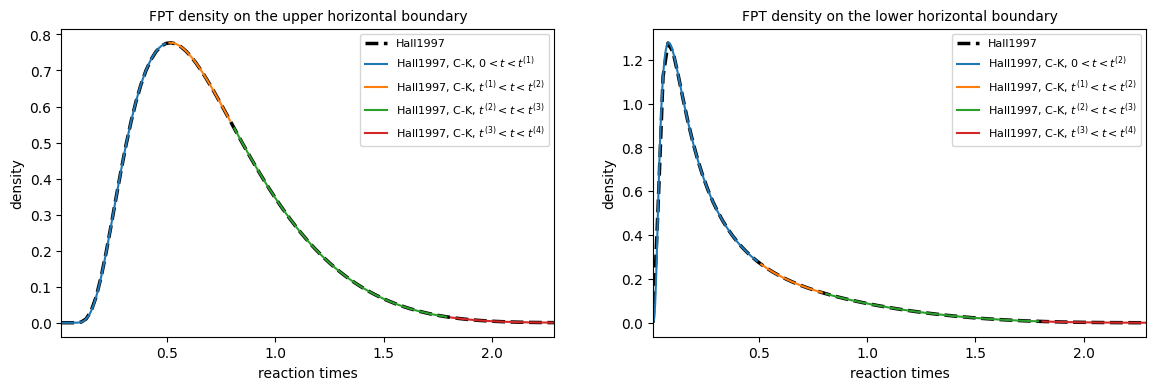

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
ax[0].plot(ts, probu_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[0].plot(t1s, p1u_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[0].plot(t2s, p2u_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[0].plot(t3s, p3u_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[0].plot(t4s, p4u_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[0].legend(fontsize=8)
ax[0].set_title("FPT density on the upper horizontal boundary", fontsize=10)
ax[0].set_xlabel("reaction times")
ax[0].set_ylabel("density")
ax[0].autoscale(tight=True, axis="x")

ax[1].plot(ts, probl_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[1].plot(t1s, p1l_list, label="Hall1997, C-K, " + "$0<t<t^{(2)}$")
ax[1].plot(t2s, p2l_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[1].plot(t3s, p3l_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[1].plot(t4s, p4l_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[1].legend(fontsize=8)
ax[1].set_title("FPT density on the lower horizontal boundary", fontsize=10)
ax[1].set_xlabel("reaction times")
ax[1].set_ylabel("density")
ax[1].autoscale(tight=True, axis="x")

plt.show()

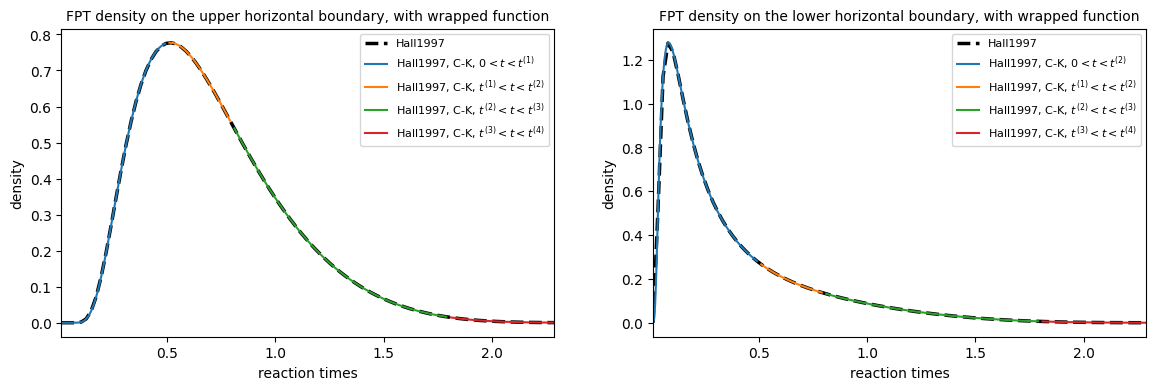

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=100)
ax[0].plot(ts, probu_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[0].plot(t1s, p1u_fun_list, label="Hall1997, C-K, " + "$0 <t<t^{(1)}$")
ax[0].plot(t2s, p2u_fun_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[0].plot(t3s, p3u_fun_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[0].plot(t4s, p4u_fun_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[0].legend(fontsize=8)
ax[0].set_title("FPT density on the upper horizontal boundary, with wrapped function", fontsize=10)
ax[0].set_xlabel("reaction times")
ax[0].set_ylabel("density")
ax[0].autoscale(tight=True, axis="x")

ax[1].plot(ts, probl_list, color="k", linestyle="--", linewidth=2.5, label="Hall1997")
ax[1].plot(t1s, p1l_fun_list, label="Hall1997, C-K, " + "$0<t<t^{(2)}$")
ax[1].plot(t2s, p2l_fun_list, label="Hall1997, C-K, " + "$t^{(1)}<t<t^{(2)}$")
ax[1].plot(t3s, p3l_fun_list, label="Hall1997, C-K, " + "$t^{(2)}<t<t^{(3)}$")
ax[1].plot(t4s, p4l_fun_list, label="Hall1997, C-K, " + "$t^{(3)}<t<t^{(4)}$")
ax[1].legend(fontsize=8)
ax[1].set_title("FPT density on the lower horizontal boundary, with wrapped function", fontsize=10)
ax[1].set_xlabel("reaction times")
ax[1].set_ylabel("density")
ax[1].autoscale(tight=True, axis="x")

plt.show()

In [14]:
%timeit -r 5 -n 100 get_fptd_aAngle_gauss(2.0, mu_list=[mu, mu, mu, mu], t_list=[t1, t2, t3], a=a, theta=theta, x0=x0, bdy=-1)

1.93 ms ± 86.1 µs per loop (mean ± std. dev. of 5 runs, 100 loops each)


#### Some thoughts...
1. Numerical integration: trapezoidal vs Gauss, accurate but slow in high dimension
2. Monte Carlo (with importance sampling): less accurate but scalable, may be more useful when there are more time steps

In [15]:
# uniform as averaging of point mass, creates discontinuity
# trunc_num? NO
# sequential time
# write something
# gamma distribution
# limit distribution: bessel?

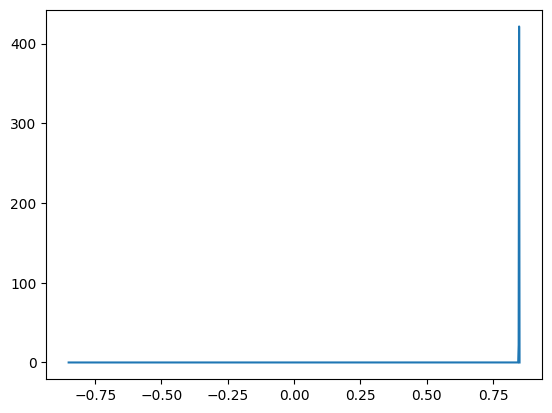

In [16]:
t = t1 + 1e-6
f_list = []
integrand = lambda x1: p(x1, t1, x0, 0) * fu(t, x1, t1)
x1s = np.linspace(lower_bdy(t1), upper_bdy(t1), 1000)
for x1 in x1s:
    f_list.append(integrand(x1))

plt.plot(x1s, f_list)

In [17]:
p2u_list_test = []
for t in t2s:
    integrand = lambda x1: p(x1, t1, x0, 0) * fl(t, x1, t1)
    p2u_list_test.append(
        Gauss_quad_nD(integrand, [[lower_bdy(t1), upper_bdy(t1)]], orders=10)
    )

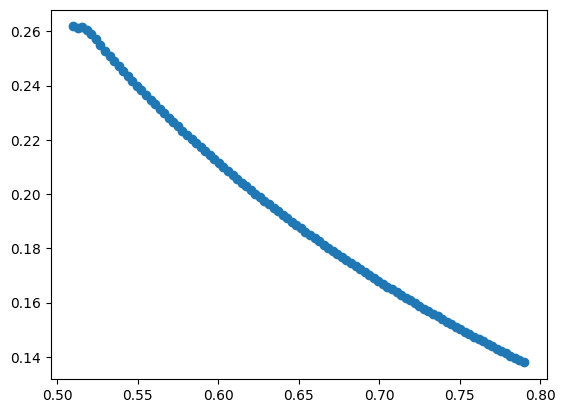

In [18]:
plt.scatter(t2s, p2u_list_test)